In [1]:
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import prim, feature_scoring, dimensional_stacking
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
from SALib.analyze.sobol import analyze

# 1. Load the CSVs

In `Step1_Simulate_Open_Exploration.py` we created six different CSV documents, we will now load them so we can use them for open exploration of the simulations. These six document form three pairs of experiments and outputs.

In [2]:
# Specify directory where CSVs are located
input_dir = os.path.join('data', 'output_data')

# Load the saved CSV files into variables
random_experiments_df = pd.read_csv(os.path.join(input_dir, 'random_experiments.csv'))
random_outcomes_df = pd.read_csv(os.path.join(input_dir, 'random_outcomes.csv'))
sobol_experiments_df = pd.read_csv(os.path.join(input_dir, 'sobol_experiments.csv'))
sobol_outcomes_df = pd.read_csv(os.path.join(input_dir, 'sobol_outcomes.csv'))
no_policy_experiments_df = pd.read_csv(os.path.join(input_dir, 'no_policy_experiments.csv'))
no_policy_outcomes_df = pd.read_csv(os.path.join(input_dir, 'no_policy_outcomes.csv'))

Let us now clean up the files a little bit by removing the unnamed columns as these do not really add to the analysis of the outputs later on.

In [3]:
# Load the saved CSV files into variables
random_experiments_df = random_experiments_df.drop(columns='Unnamed: 0')
random_outcomes_df = random_outcomes_df.drop(columns='Unnamed: 0')
sobol_experiments_df = sobol_experiments_df.drop(columns='Unnamed: 0')
sobol_outcomes_df = sobol_outcomes_df.drop(columns='Unnamed: 0')
no_policy_experiments_df = no_policy_experiments_df.drop(columns='Unnamed: 0')
no_policy_outcomes_df = no_policy_outcomes_df.drop(columns='Unnamed: 0')


In [4]:
print(random_outcomes_df)

     Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
0              2.599588e+06           6.124302e+08          1.471100e+09   
1              2.333763e+06           6.124302e+08          1.471100e+09   
2              1.491311e+07           6.124302e+08          1.471100e+09   
3              3.168450e+06           6.124302e+08          1.471100e+09   
4              1.764653e+07           6.124302e+08          1.471100e+09   
..                      ...                    ...                   ...   
995            1.529899e+07           6.438899e+08          1.426700e+09   
996            1.227796e+07           6.438899e+08          1.426700e+09   
997            2.240126e+08           6.438899e+08          1.426700e+09   
998            7.589451e+06           6.438899e+08          1.426700e+09   
999            5.754389e+08           6.438899e+08          1.426700e+09   

     Evacuation Costs  Expected Number of Deaths  policy  
0           65.975896       

In [1]:
print(random_experiments_df)

NameError: name 'random_experiments_df' is not defined

# 2. Runs with No Policy

Let us start of by analyzing the scenarios where we have no policies implemented (we have a kind of basecase that remains the same), but where we change the uncertainties within the uncertainty space for 10,000 different combinations. 
We will look at this and do 5 things; visualizing the scenarios using a seaborn pairplot, feature scoring, dimensional stacking, PRIM,and sensitivity analysis.

## 2.1. Pairplot

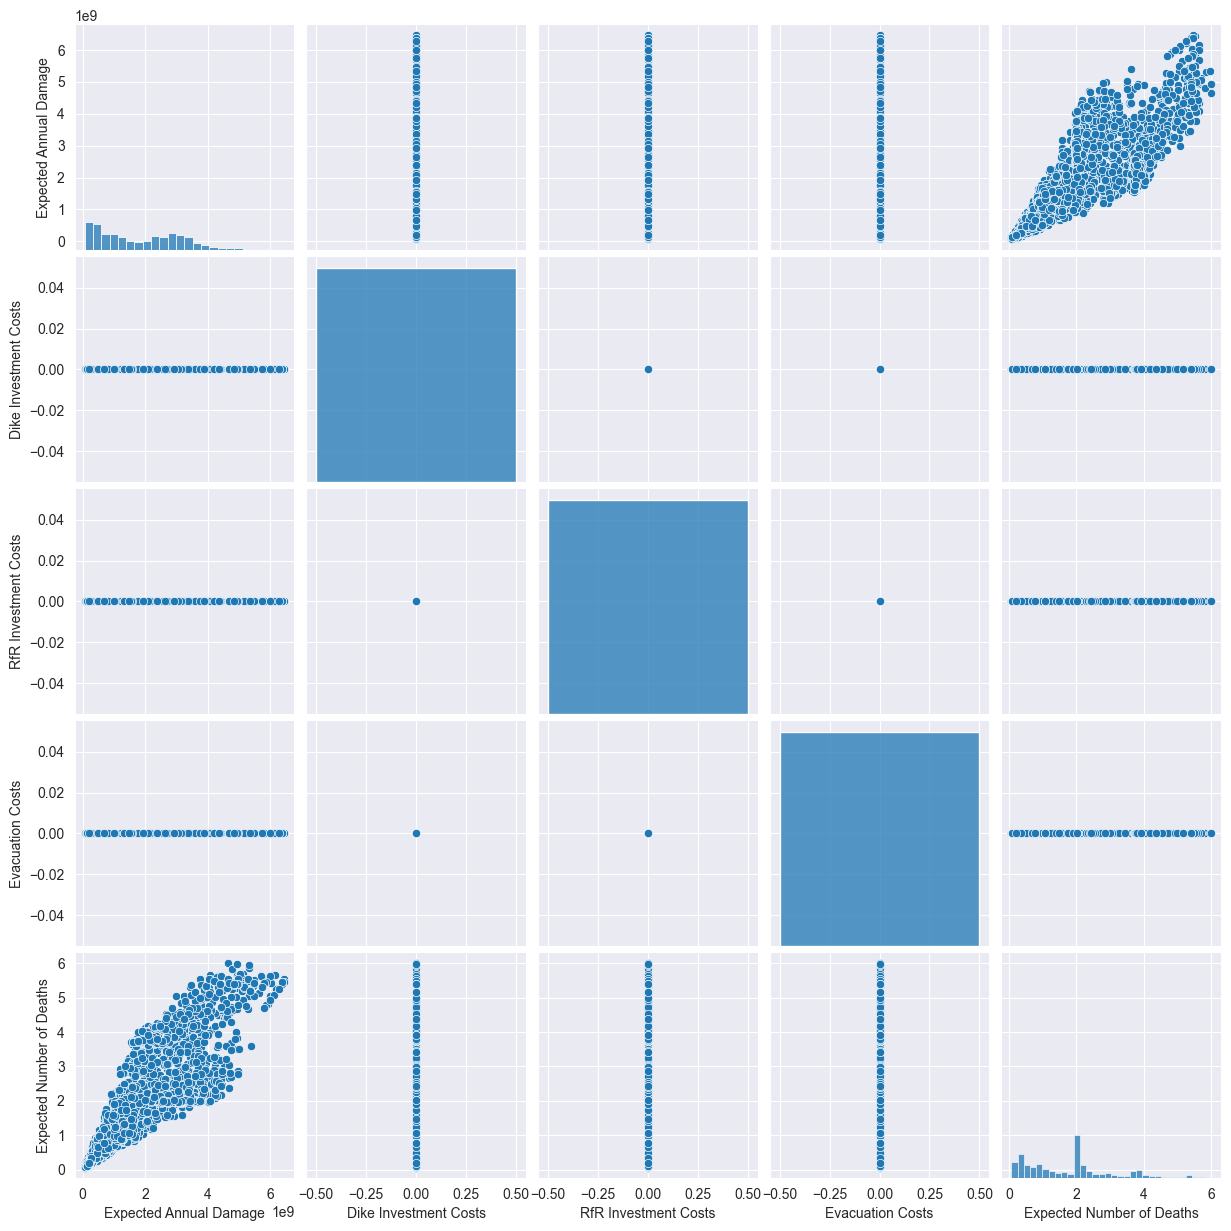

In [5]:
# Create multi scatter plot for zero policy
sns.pairplot(no_policy_outcomes_df)
plt.show()

## 2.2. Feature Scoring

In [6]:
# Initialize the dike model from the problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(2)

# Access and print the uncertainties
dike_model_uncertainties = dike_model.uncertainties

# Create a list of uncertainty names
uncertainties = []

# Print out each uncertainty in the list
for uncertainty in dike_model_uncertainties:
    uncertainties.append(uncertainty.name)
    
print(uncertainties)  

['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']


In [7]:
no_policy_experiments_uncertainties = no_policy_experiments_df.loc[:,uncertainties]

print(no_policy_experiments_uncertainties)

      discount rate 0  discount rate 1  discount rate 2  \
0                 2.5              2.5              1.5   
1                 1.5              2.5              1.5   
2                 3.5              4.5              4.5   
3                 2.5              4.5              3.5   
4                 3.5              3.5              1.5   
...               ...              ...              ...   
4995              4.5              3.5              3.5   
4996              4.5              3.5              1.5   
4997              3.5              3.5              1.5   
4998              1.5              2.5              2.5   
4999              4.5              4.5              3.5   

      A.0_ID flood wave shape    A.1_Bmax  A.1_pfail  A.1_Brate    A.2_Bmax  \
0                          74  254.176687   0.697251        1.0  256.574418   
1                          62  274.166524   0.657876        1.0  226.545292   
2                         112  161.492738   0.670765  

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


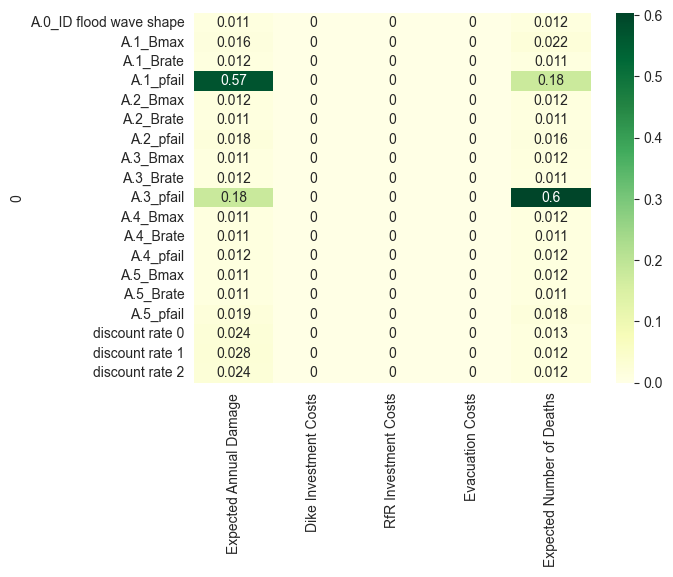

In [8]:
# Let us now calculate the feature scores for the different uncertainties, and their impact on the outcomes of interest
feature_scores = feature_scoring.get_feature_scores_all(no_policy_experiments_uncertainties, no_policy_outcomes_df.drop(columns='policy'))
sns.heatmap(feature_scores, cmap="YlGn", annot=True)
plt.show()

## 2.3. Dimensional Stacking

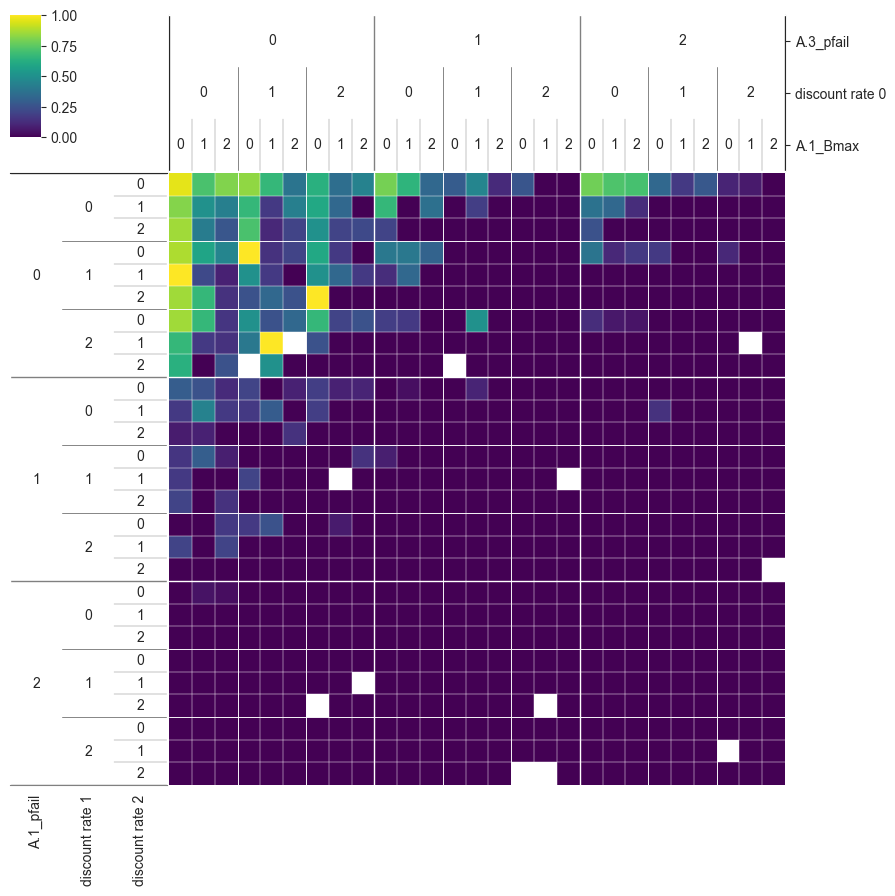

In [9]:
x_no_policy = no_policy_experiments_uncertainties
y_no_policy = no_policy_outcomes_df['Expected Annual Damage'].values > np.percentile(no_policy_outcomes_df['Expected Annual Damage'],90)

dimensional_stacking.create_pivot_plot(x_no_policy,y_no_policy, nr_levels=3)
plt.show()

## 2.4. PRIM

### Variable 1

In [10]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_no_policy, y_no_policy, threshold=0.4, peel_alpha= 0.1)
box1 = prim_alg.find_box()

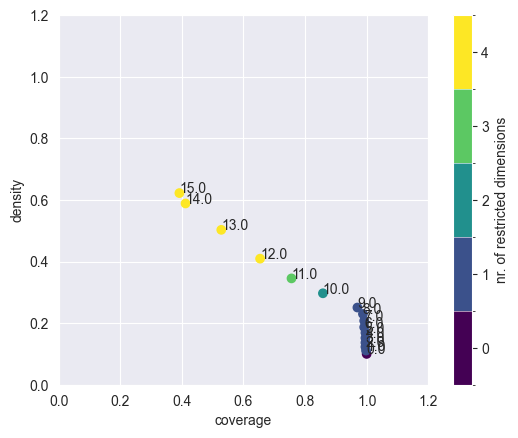

In [11]:
# Let's show the created boxes
box1.show_tradeoff(annotated=True)
plt.show()

In [12]:
# Box X has been selected due to the +/- 80% density
box_number_of_choice = 12
box1.inspect(box_number_of_choice)[0]

coverage      0.654000
density       0.409262
id           12.000000
k           327.000000
mass          0.159800
mean          0.409262
n           799.000000
res_dim       4.000000
Name: 12, dtype: float64

                   box 12                                 
                      min       max qp value      qp value
A.1_pfail        0.000109  0.386937      NaN  1.244175e-61
discount rate 0  1.500000  4.000000      NaN  7.061814e-05
discount rate 2  1.500000  4.000000      NaN  9.686865e-05
discount rate 1  1.500000  4.000000      NaN  1.523997e-04


[<Figure size 640x480 with 1 Axes>]

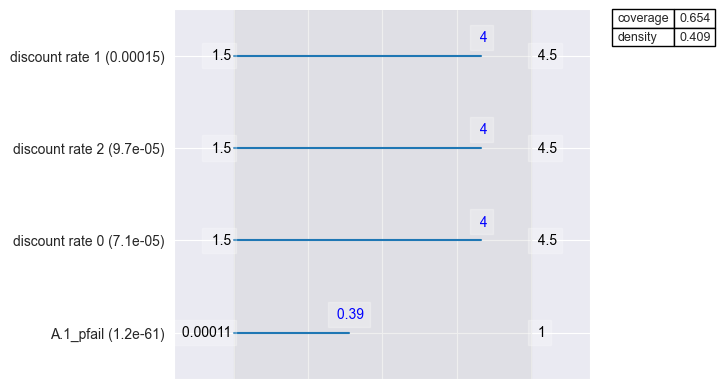

In [13]:
box1.inspect(box_number_of_choice, style="graph")

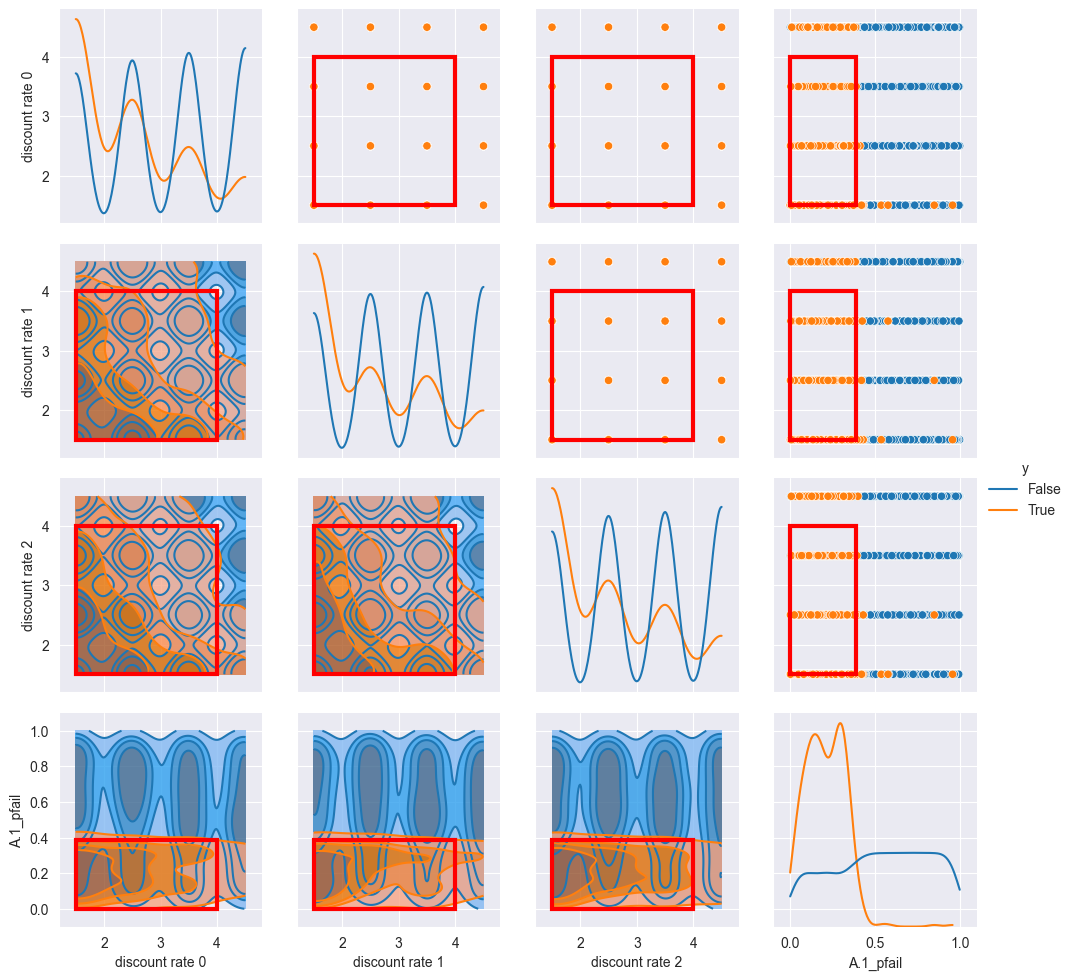

In [14]:
box1.show_pairs_scatter(box_number_of_choice)
plt.show()

#### Let us resample

In [15]:
box1.resample(box_number_of_choice)

,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
discount rate 0,100.0,90.0
discount rate 1,80.0,90.0
discount rate 2,70.0,70.0
A.1_Bmax,20.0,20.0
A.5_pfail,10.0,10.0
A.0_ID flood wave shape,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_pfail,0.0,0.0


The first X parameters can exactly reproduce coverage and density, confirming the suggestion of highly significant quasi p values. The third and fourth are also relatively reliable given their values with an average of 90 and 65 for reproducability.  


### Variable 2

## 2.5. Sensitivity Analysis

# 3. 200 Policy Runs --> Think about which policies (maybe the water board is not open to all policies (do they want RfR, or do they want higher dikes? or both not))

We will now look at 200 different policies under 1,000 different scenarios to create insight into 200,000 potential futures. We will again apply the five different methods, that we used in step 2 above.

## 3.1. Pairplot

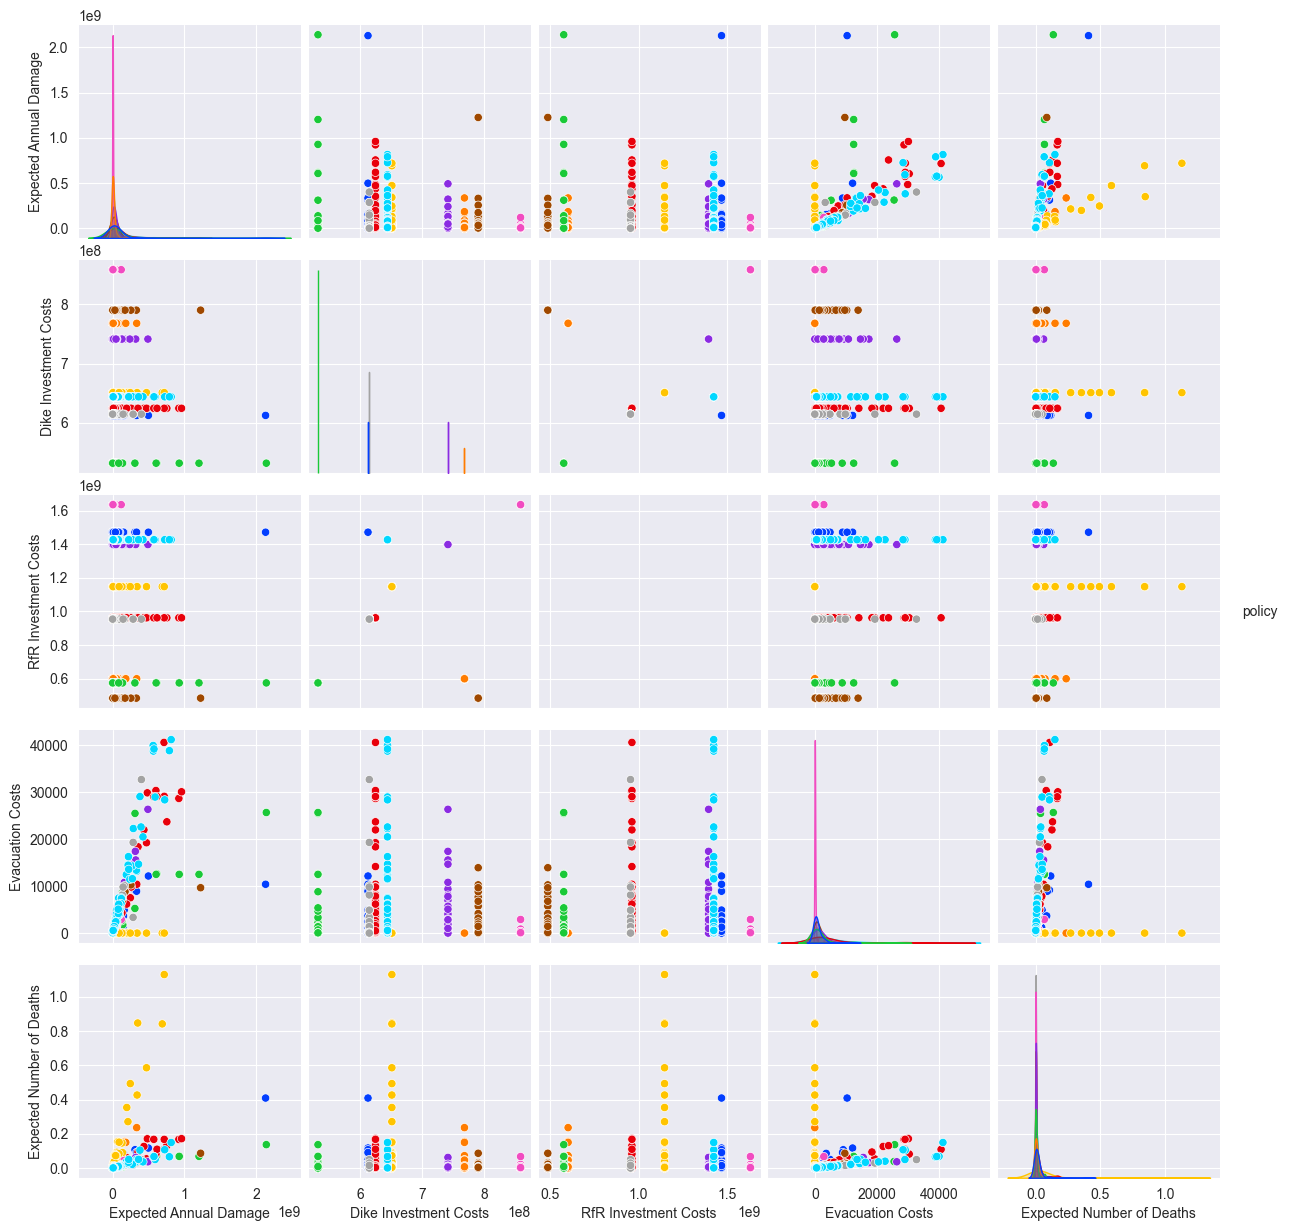

In [16]:
# Create multi scatter plot for zero policy
sns.pairplot(random_outcomes_df, hue='policy', plot_kws={'legend': None}, palette='bright')
plt.legend([], [], frameon=False)  # Hide the legend
plt.show()

## 3.2. Feature Scoring

In [17]:
random_experiments_uncertainties = random_experiments_df.loc[:,uncertainties]

print(random_experiments_uncertainties)

     discount rate 0  discount rate 1  discount rate 2  \
0                2.5              4.5              4.5   
1                4.5              1.5              4.5   
2                1.5              2.5              4.5   
3                4.5              3.5              1.5   
4                2.5              3.5              3.5   
..               ...              ...              ...   
995              2.5              3.5              2.5   
996              3.5              1.5              3.5   
997              3.5              1.5              2.5   
998              3.5              4.5              2.5   
999              2.5              4.5              3.5   

     A.0_ID flood wave shape    A.1_Bmax  A.1_pfail  A.1_Brate    A.2_Bmax  \
0                        118   79.717455   0.606774        1.5  180.795632   
1                         62  245.101380   0.908261        1.0   75.140929   
2                         87  155.071028   0.829017       10.0   56.3

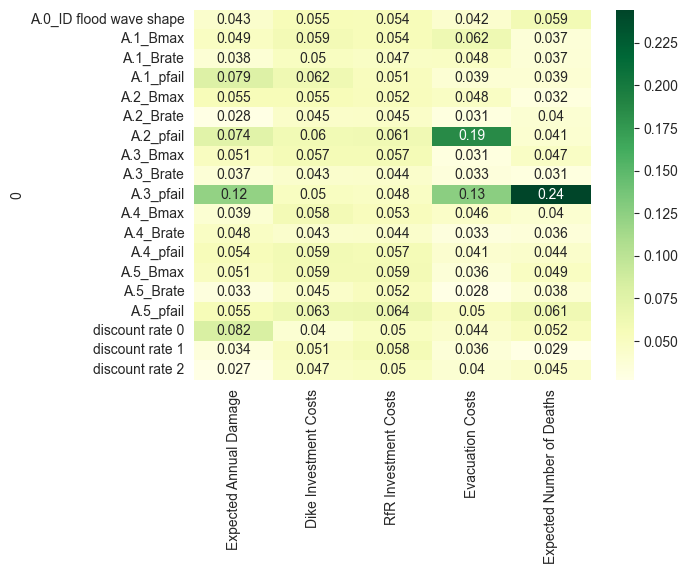

In [18]:
# Let us now calculate the feature scores for the different uncertainties, and their impact on the outcomes of interest
feature_scores = feature_scoring.get_feature_scores_all(random_experiments_uncertainties, random_outcomes_df.drop(columns='policy'))
sns.heatmap(feature_scores, cmap="YlGn", annot=True)
plt.show()

## 3.3. Dimensional Stacking

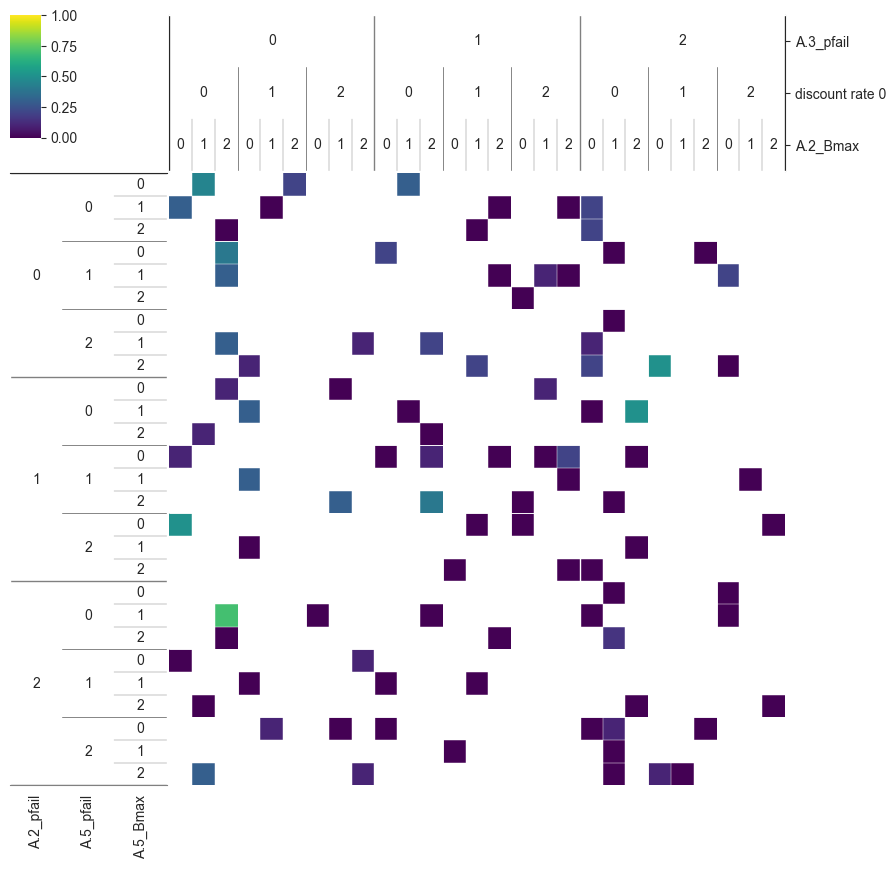

In [19]:
x_random_policy = random_experiments_uncertainties
y_random_policy = random_outcomes_df['Expected Annual Damage'].values > np.percentile(random_outcomes_df['Expected Annual Damage'], 90)

dimensional_stacking.create_pivot_plot(x_random_policy,y_random_policy, nr_levels=3)
plt.show()

### Variable 1

In [20]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_no_policy, y_no_policy, threshold=0.4, peel_alpha= 0.1)
box2 = prim_alg.find_box()

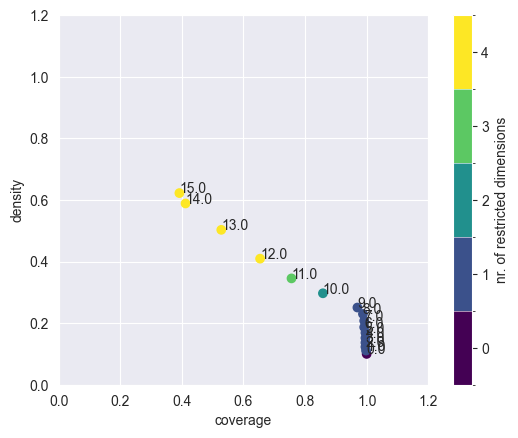

In [21]:
# Let's show the created boxes
box2.show_tradeoff(annotated=True)
plt.show()

[<Figure size 640x480 with 1 Axes>]

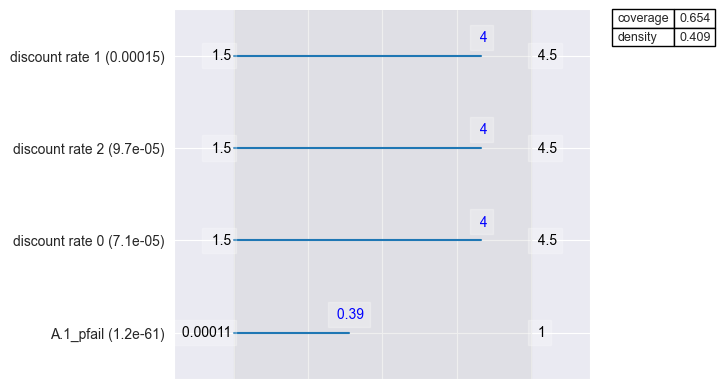

In [22]:
box2.inspect(box_number_of_choice, style="graph")

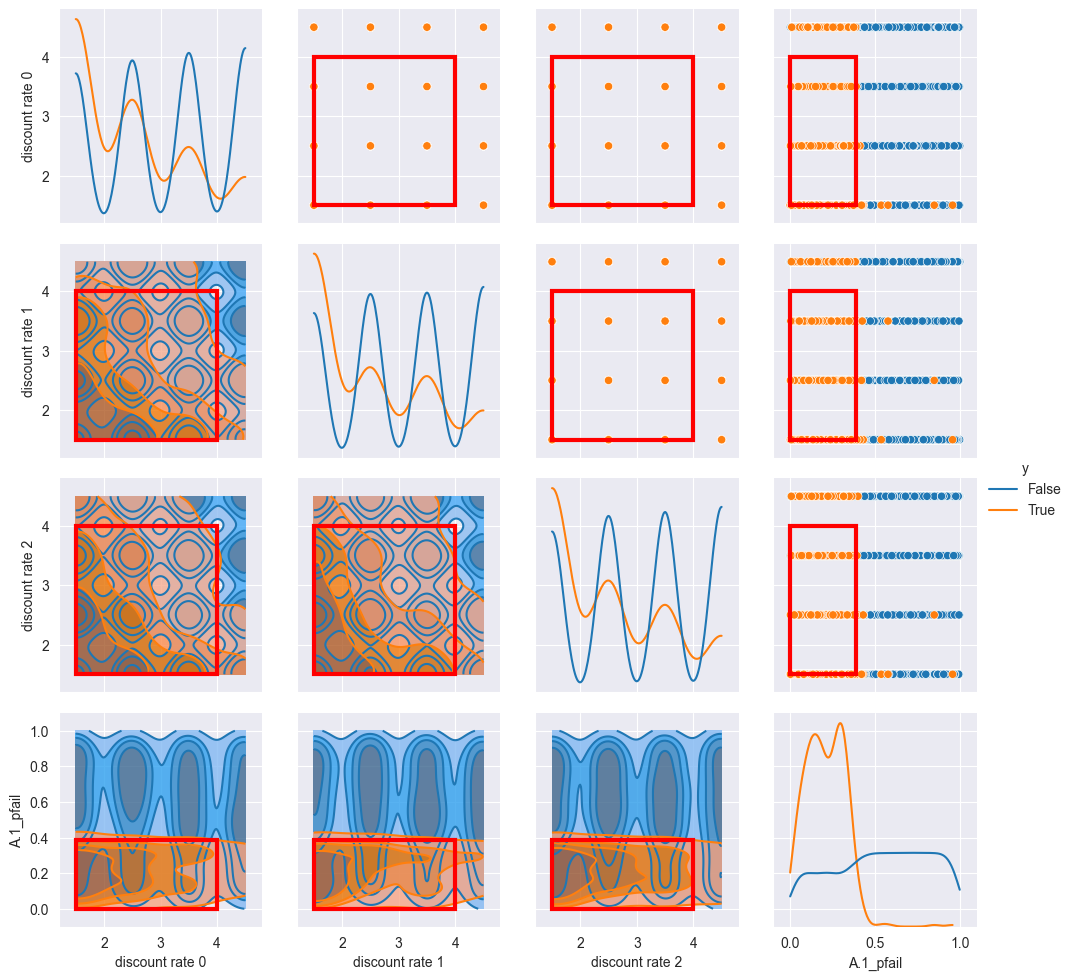

In [23]:
box2.show_pairs_scatter(box_number_of_choice)
plt.show()

#### Let us resample

In [24]:
box2.resample(box_number_of_choice)

,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
discount rate 0,90.0,90.0
discount rate 2,70.0,80.0
discount rate 1,50.0,60.0
A.1_Bmax,30.0,30.0
A.5_pfail,10.0,10.0
A.0_ID flood wave shape,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_pfail,0.0,0.0


# 4. Sensitivity Analysis

In [26]:
problem = get_SALib_problem(dike_model.uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [27]:
print(f"Shape of experiments: {sobol_experiments_df.shape}, Shape of outcomes: {sobol_outcomes_df.shape}")

Shape of experiments: (10240, 53), Shape of outcomes: (10240, 5)


In [28]:
sobol_experiments_uncertainties = sobol_experiments_df.loc[:,uncertainties]

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

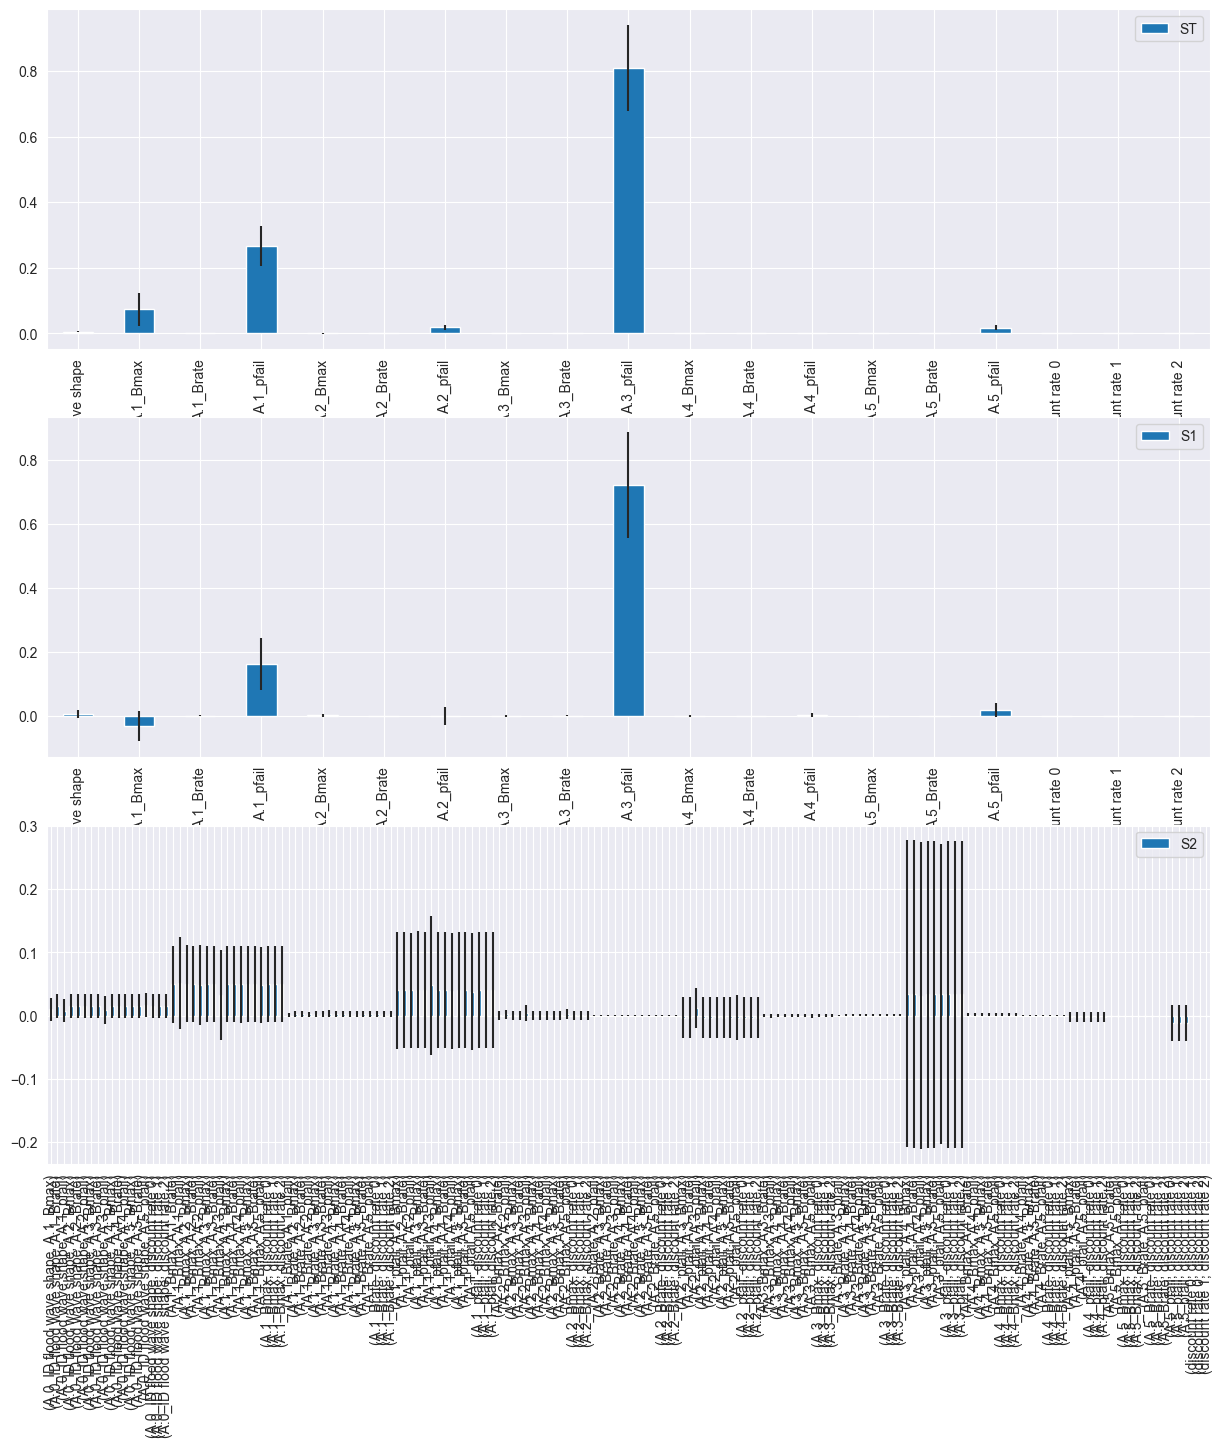

In [29]:
sobol_results = {}

for policy in sobol_experiments_df.policy.unique():
    logical = sobol_experiments_df.policy == policy
    y = sobol_outcomes_df.loc[logical,'Expected Number of Deaths'].values
    indices = analyze(problem, y)
    sobol_results[policy] = indices

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 15)
indices.plot(ax=axes)

In [45]:
def sobol_sensitivity_analysis(outcome_variable, sobol_outcomes, problem):
    """
    Perform Sobol sensitivity analysis for a specified outcome variable and plot the results.

    Parameters
    ----------
    outcome_variable : str
        The name of the outcome variable to analyze.
    sobol_outcomes : pd.DataFrame
        DataFrame containing the outcomes from the Sobol sensitivity analysis.
    problem : dict
        The problem definition for SALib.
    
    Returns
    -------
    Si : dict
        The Sobol sensitivity indices.
    """
    # Calculate mean and standard deviation for the specified outcome variable
    outcome_value = sobol_outcomes[outcome_variable].values

    # Perform Sobol analysis
    Si = sobol.analyze(problem, outcome_value, calc_second_order=True, print_to_console=True)

    # Filter Sobol indices to relevant metrics
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    # Plot Sobol indices
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]

    indices.plot.bar(yerr=err.values.T, ax=ax)
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()

    return Si

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.005601  0.002108
A.1_Bmax                 0.073390  0.049267
A.1_Brate                0.000022  0.000024
A.1_pfail                0.266166  0.056264
A.2_Bmax                 0.000939  0.000993
A.2_Brate                0.000007  0.000006
A.2_pfail                0.018581  0.005553
A.3_Bmax                 0.000078  0.000076
A.3_Brate                0.000025  0.000028
A.3_pfail                0.809368  0.116505
A.4_Bmax                 0.000027  0.000043
A.4_Brate                0.000004  0.000007
A.4_pfail                0.001110  0.000708
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.017560  0.006690
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape  0.004915  0.010724
A.1_Bmax                -0.03222

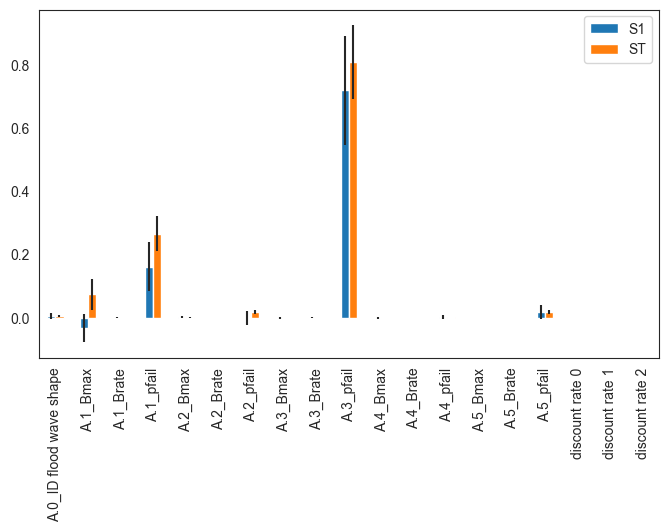

{'S1': array([ 4.91524285e-03, -3.22278844e-02,  9.34125609e-06,  1.61851476e-01,
         1.76770581e-03,  1.15957448e-04, -1.15521008e-03, -6.99398593e-04,
        -1.72133805e-04,  7.20325142e-01, -1.27917870e-03, -5.07625016e-04,
         2.36156280e-03,  0.00000000e+00,  0.00000000e+00,  1.68352474e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'S1_conf': array([1.07241258e-02, 4.40667853e-02, 5.69845664e-04, 7.72927713e-02,
        4.05722473e-03, 1.24415472e-04, 2.18162157e-02, 2.17219711e-03,
        1.74949740e-03, 1.72173819e-01, 2.19944297e-03, 8.71635467e-04,
        6.55894651e-03, 0.00000000e+00, 0.00000000e+00, 2.22777198e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'ST': array([5.60066382e-03, 7.33897710e-02, 2.17528335e-05, 2.66165805e-01,
        9.38714121e-04, 6.68143151e-06, 1.85811513e-02, 7.75474213e-05,
        2.53808184e-05, 8.09367518e-01, 2.69547515e-05, 3.91098520e-06,
        1.10994536e-03, 0.00000000e+00, 0.00000000

In [46]:
outcome_variable = 'Expected Number of Deaths'
sobol_sensitivity_analysis(outcome_variable, sobol_outcomes_df, problem)

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.004450  0.001963
A.1_Bmax                 0.029617  0.016462
A.1_Brate                0.000012  0.000009
A.1_pfail                0.699014  0.109320
A.2_Bmax                 0.000333  0.000353
A.2_Brate                0.000005  0.000005
A.2_pfail                0.022810  0.007164
A.3_Bmax                 0.000111  0.000109
A.3_Brate                0.000034  0.000047
A.3_pfail                0.264425  0.047857
A.4_Bmax                 0.000043  0.000070
A.4_Brate                0.000006  0.000011
A.4_pfail                0.001095  0.000575
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.023332  0.008895
discount rate 0          0.023418  0.006019
discount rate 1          0.019808  0.004291
discount rate 2          0.021761  0.005026
                               S1   S1_conf
A.0_ID flood wave shape -0.001280  0.009119
A.1_Bmax                -0.00958

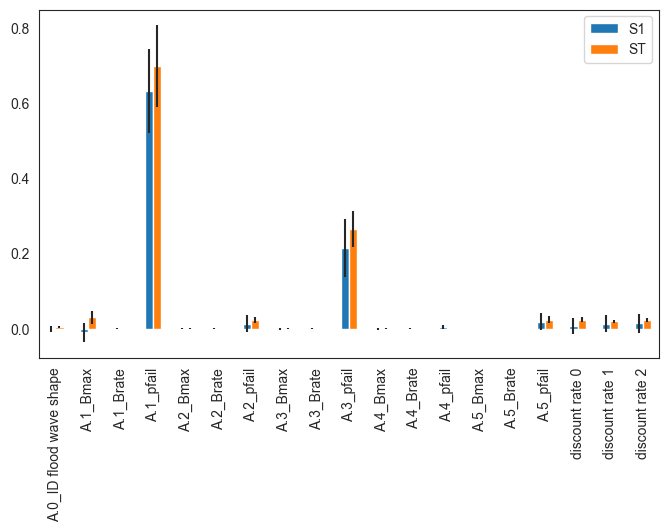

{'S1': array([-1.27988534e-03, -9.58115164e-03,  1.22958472e-04,  6.33146892e-01,
         4.46033804e-04,  1.85510428e-04,  1.30378818e-02, -9.21528745e-04,
         1.22046739e-04,  2.14303956e-01, -1.40356162e-03, -5.27260832e-04,
         3.52422002e-03,  0.00000000e+00,  0.00000000e+00,  1.86543996e-02,
         6.54892633e-03,  1.26005860e-02,  1.43554731e-02]),
 'S1_conf': array([0.00911903, 0.02552727, 0.00060597, 0.11311419, 0.00190282,
        0.00040553, 0.02262421, 0.00198185, 0.00105165, 0.07815363,
        0.00228254, 0.00087708, 0.00506373, 0.        , 0.        ,
        0.02268103, 0.02077152, 0.02219547, 0.02520492]),
 'ST': array([4.44956473e-03, 2.96168766e-02, 1.16905669e-05, 6.99014445e-01,
        3.33447994e-04, 4.67403446e-06, 2.28100948e-02, 1.11386444e-04,
        3.39152526e-05, 2.64425430e-01, 4.30323603e-05, 6.09635395e-06,
        1.09512509e-03, 0.00000000e+00, 0.00000000e+00, 2.33319441e-02,
        2.34184172e-02, 1.98078394e-02, 2.17610103e-02]),
 'ST

In [47]:
outcome_variable = 'Expected Annual Damage'
sobol_sensitivity_analysis(outcome_variable, sobol_outcomes_df, problem)